# Example 1: Umbrella Sampling in 1D

In this example, we will perform umbrella sampling along the **x-coordinate** for a particle on a 2-dimensional potential energy surface, and construct a free energy profile from the biased umbrella sampling data using WHAM.

We will use OpenMM to perform langevin dynamics simulations of a particle on a 2-dimensional potential energy surface. To learn more about OpenMM, visit https://openmm.org/

`single_particle_ld.py` contains the classes we will use to run these simulations.

In [1]:
# Imports
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import WHAM
sys.path.append('.')
import single_particle_ld

## Visualize potential

[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2


(<Figure size 900x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe02aed1310>)

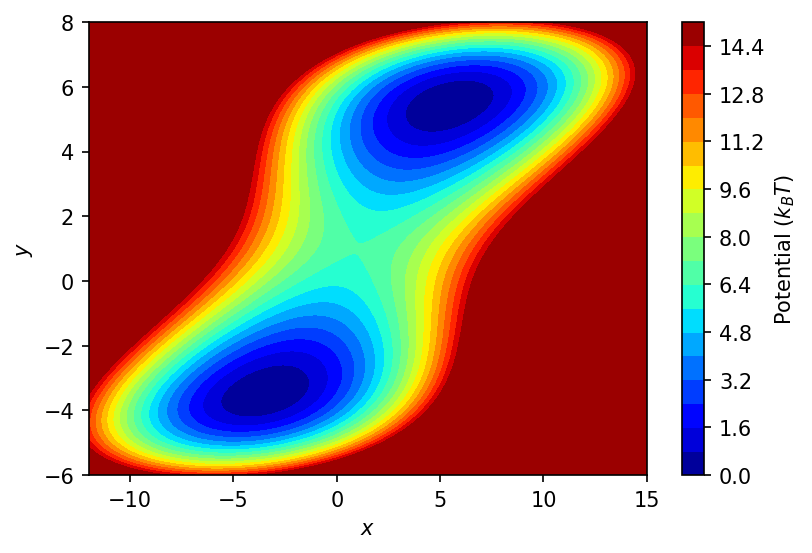

In [2]:
pot = single_particle_ld.TwoBasinPotential2D()
vis = single_particle_ld.VisualizePotential2D(pot, temp=300,
                                              xrange=[-12, 15], yrange=[-6, 8],
                                              contourvals=20, clip=15)
vis.plot_potential()

## Unbiased simulation

Let's run a 500 ps unbiased simulation of a particle on this landscape:

In [3]:
if not os.path.exists("examples_out/1D_US/unbiased"):
    os.makedirs("examples_out/1D_US/unbiased")
    
pot = single_particle_ld.TwoBasinPotential2D()

sim = single_particle_ld.SingleParticleSimulation(pot,
                                                  init_coord=np.array([[-5, -4, 0]]),
                                                  cpu_threads=1)
sim(nsteps=50000 + 1,
    chkevery=10000,
    trajevery=10,
    energyevery=10,
    chkfile="examples_out/1D_US/unbiased/chk_state.pkl",
    trajfile="examples_out/1D_US/unbiased/traj.dat",
    energyfile="examples_out/1D_US/unbiased/energies.dat")

t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/unbiased/traj.dat").read_traj()

[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
Running simulation on 1 CPU threads.


 24%|████████████▉                                         | 11926/50001 [00:00<00:02, 14854.24it/s]

Checkpoint at 100.0000000 ps


 45%|████████████████████████                              | 22298/50001 [00:01<00:01, 14526.97it/s]

Checkpoint at 200.0000000 ps


 65%|███████████████████████████████████▏                  | 32556/50001 [00:02<00:01, 14560.55it/s]

Checkpoint at 300.0000000 ps


 83%|████████████████████████████████████████████▌         | 41261/50001 [00:02<00:00, 14233.86it/s]

Checkpoint at 400.0000000 ps


100%|██████████████████████████████████████████████████████| 50001/50001 [00:03<00:00, 14151.11it/s]

Checkpoint at 500.0000000 ps
Checkpoint at 500.0000000 ps


### Visualize time-series

Text(0, 0.5, 'y')

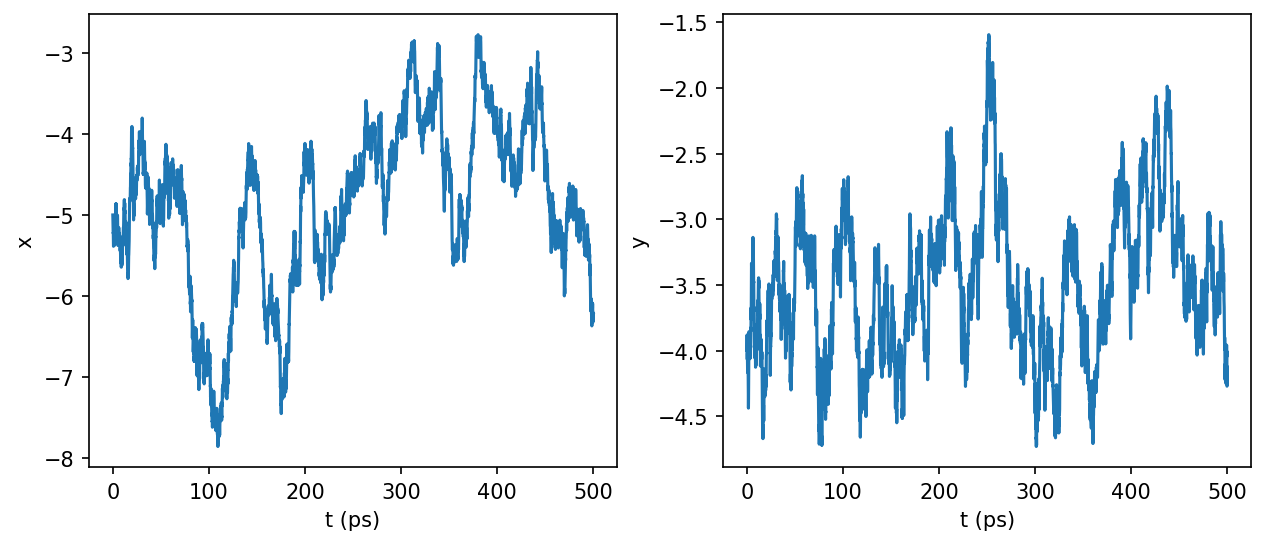

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
ax[0].plot(t, traj[:, 0])
ax[1].plot(t, traj[:, 1])
ax[0].set_xlabel("t (ps)")
ax[1].set_xlabel("t (ps)")
ax[0].set_ylabel("x")
ax[1].set_ylabel("y")

### Visualize trajectory in 2D

(<Figure size 900x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe02f1c7950>)

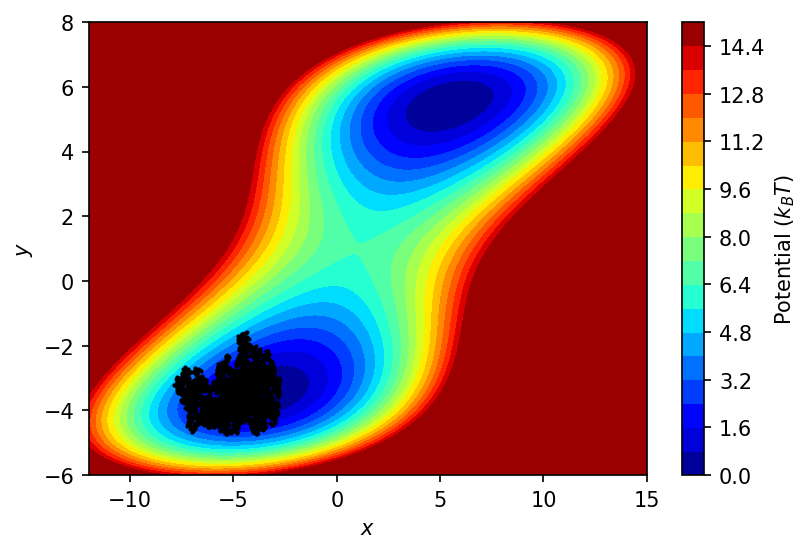

In [5]:
vis.scatter_traj(traj)

### Visualize trajectory in 1D

100%|██████████████████████████████████████████████████████████| 5001/5001 [00:20<00:00, 238.98it/s]


(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe02fc20250>)

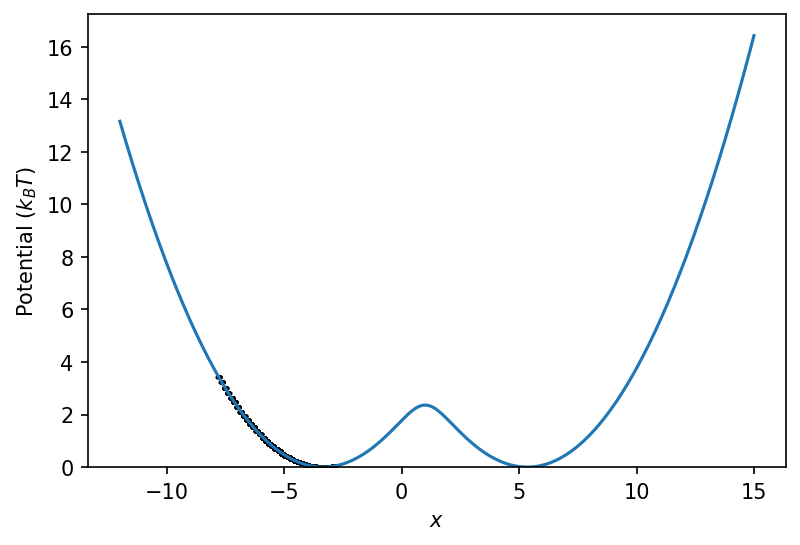

In [6]:
vis.scatter_traj_projection_x(traj)

## Biased simulation

We can localize the x-coordinate of the particle using a harmonic potential of the form $\frac{\kappa}{2} (x - x_0)^2$.

Here's an example, with $\kappa = 2$ and $x_0 = 0$.

In [7]:
if not os.path.exists("examples_out/1D_US/biased/test"):
    os.makedirs("examples_out/1D_US/biased/test")
    
pot = single_particle_ld.TwoBasinPotential2D()

umbrella = single_particle_ld.HarmonicBias(kappa_x=2, x_0=0)

sim = single_particle_ld.SingleParticleSimulation(pot,
                                                  bias=umbrella,
                                                  init_coord=np.array([[-5, -4, 0]]),
                                                  cpu_threads=1)
sim(nsteps=50000 + 1,
    chkevery=10000,
    trajevery=10,
    energyevery=10,
    chkfile="examples_out/1D_US/biased/test/chk_state.pkl",
    trajfile="examples_out/1D_US/biased/test/traj.dat",
    energyfile="examples_out/1D_US/biased/test/energies.dat")

t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/test/traj.dat").read_traj()

[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
2 / 2 * (x - 0)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 24%|████████████▉                                         | 11985/50001 [00:00<00:02, 15090.93it/s]

Checkpoint at 100.0000000 ps


 45%|████████████████████████▎                             | 22567/50001 [00:01<00:01, 15017.19it/s]

Checkpoint at 200.0000000 ps


 63%|██████████████████████████████████                    | 31557/50001 [00:02<00:01, 14930.89it/s]

Checkpoint at 300.0000000 ps


 84%|█████████████████████████████████████████████▎        | 41984/50001 [00:02<00:00, 14893.49it/s]

Checkpoint at 400.0000000 ps


100%|██████████████████████████████████████████████████████| 50001/50001 [00:03<00:00, 14553.77it/s]

Checkpoint at 500.0000000 ps
Checkpoint at 500.0000000 ps


Text(0, 0.5, 'y')

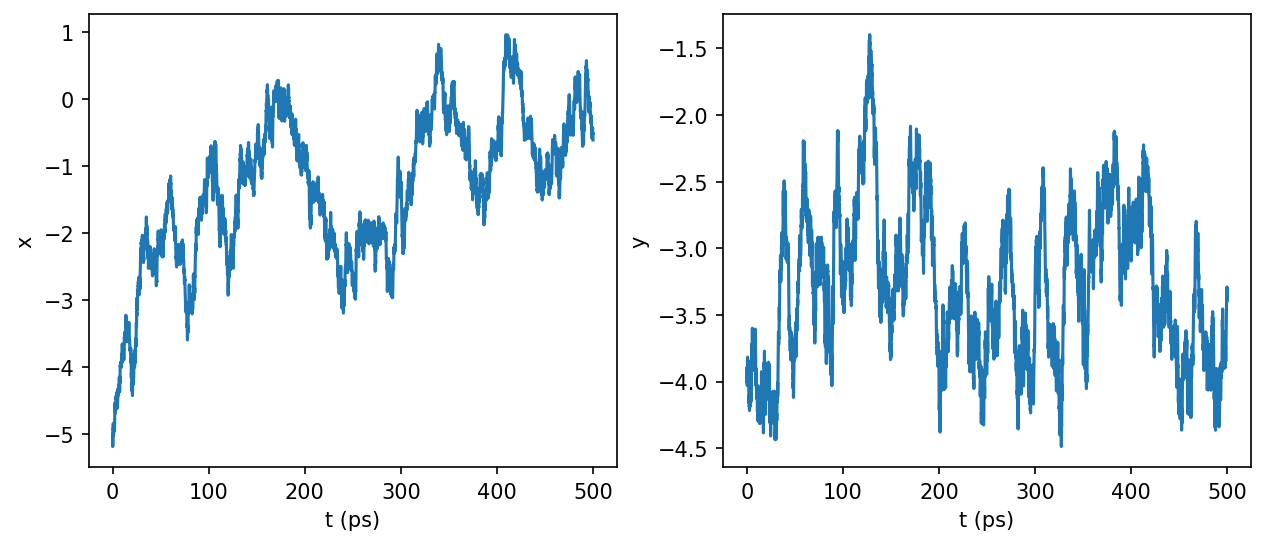

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
ax[0].plot(t, traj[:, 0])
ax[1].plot(t, traj[:, 1])
ax[0].set_xlabel("t (ps)")
ax[1].set_xlabel("t (ps)")
ax[0].set_ylabel("x")
ax[1].set_ylabel("y")

As we can see, it takes some time for the system to equilibrate. Let's discard the first 200 ps (i.e. 2000 data points) and plot the rest.

(<Figure size 900x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe015353a10>)

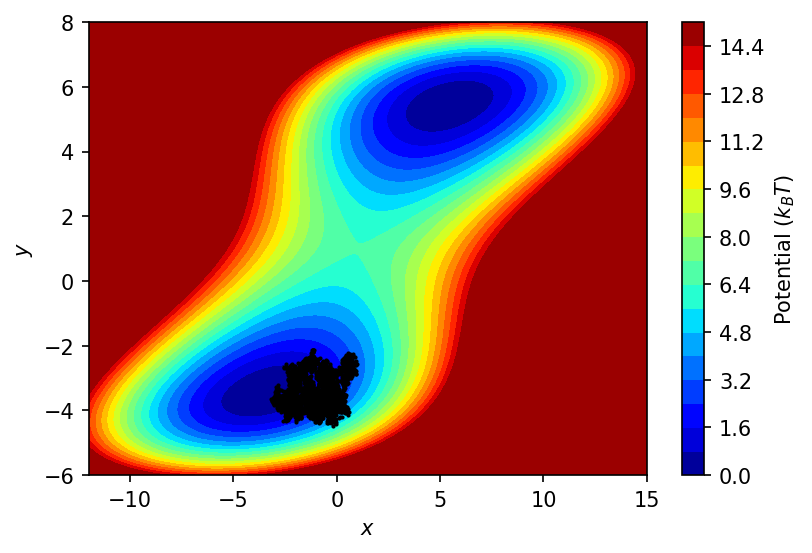

In [9]:
vis.scatter_traj(traj[2000:])

100%|██████████████████████████████████████████████████████████| 3001/3001 [00:07<00:00, 379.36it/s]


(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe01625ef90>)

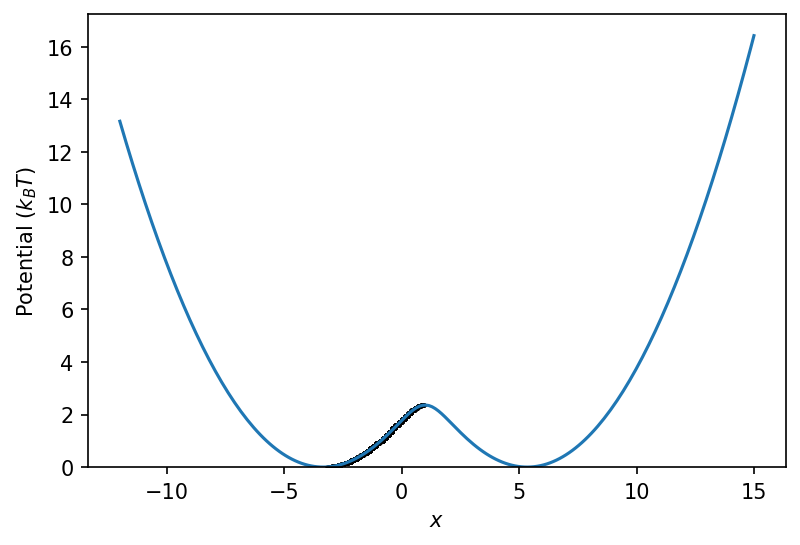

In [10]:
vis.scatter_traj_projection_x(traj[2000:])

## Umbrella sampling simulations

We can perform a series of such biased simulations with different values of $x_0$, and in the process, sample the entire landscape.

For this, we need to select a $\kappa$ and range of $x_0$ values. How do we do this?

Appendix B. in Nick Rego's PhD dissertation outlines heuristics to choose $\kappa$ and the spacing between $x_0$ values, $\Delta x_0$. 

Let's apply these heuristics:

In [11]:
_, unb_traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/unbiased/traj.dat").read_traj()

std_x = unb_traj[:, 0].std()

kappa = 4 / std_x

delta_x = 4 * np.sqrt(1 + 4) / 4 * std_x

print(kappa, delta_x)

3.8542625557720207 2.320618219587688


Let's set $\kappa = 4$ and $\Delta x_0 = 1$

In [12]:
kappa = 4
delta_x = 1 

### 2 ns simulations

We'll perform these simulations for 2 ns each, so that we have enough data to construct free energy profiles.

In [13]:
for x_0 in range(-12, 12 + 1, delta_x):
    if not os.path.exists("examples_out/1D_US/biased/k{}x{}".format(kappa, x_0)):
        os.makedirs("examples_out/1D_US/biased/k{}x{}".format(kappa, x_0))
    
    pot = single_particle_ld.TwoBasinPotential2D()

    umbrella = single_particle_ld.HarmonicBias(kappa_x=kappa, x_0=x_0)

    sim = single_particle_ld.SingleParticleSimulation(pot,
                                                      bias=umbrella,
                                                      init_coord=np.array([[-5, -4, 0]]),
                                                      cpu_threads=1)
    sim(nsteps=200000 + 1,
        chkevery=100000,
        trajevery=10,
        energyevery=10,
        chkfile="examples_out/1D_US/biased/k{}x{}/chk_state.pkl".format(kappa, x_0),
        trajfile="examples_out/1D_US/biased/k{}x{}/traj.dat".format(kappa, x_0),
        energyfile="examples_out/1D_US/biased/k{}x{}/energies.dat".format(kappa, x_0))

[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -12)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102471/200001 [00:07<00:06, 14572.75it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 14096.96it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -11)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101731/200001 [00:07<00:07, 13826.17it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13708.80it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -10)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▌                         | 102382/200001 [00:07<00:06, 14255.03it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13992.83it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -9)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▌                         | 102193/200001 [00:07<00:06, 14545.83it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13926.95it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -8)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102768/200001 [00:07<00:06, 14898.81it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13800.91it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -7)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101742/200001 [00:07<00:07, 13797.49it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 14048.07it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -6)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101825/200001 [00:07<00:06, 14391.30it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13831.93it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -5)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▌                         | 102141/200001 [00:07<00:06, 14092.69it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 14192.77it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -4)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101758/200001 [00:07<00:06, 14245.56it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13577.89it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -3)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▎                         | 101429/200001 [00:07<00:06, 14530.69it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 14219.56it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -2)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▌                         | 102082/200001 [00:07<00:06, 14560.62it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13885.68it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - -1)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102868/200001 [00:07<00:06, 14537.50it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13915.82it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 0)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101443/200001 [00:07<00:06, 14743.87it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13802.97it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 1)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102499/200001 [00:07<00:06, 14079.05it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13705.46it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 2)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▌                         | 102136/200001 [00:07<00:06, 14189.73it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13994.54it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 3)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101867/200001 [00:07<00:07, 13664.78it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 14042.28it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 4)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▌                         | 101971/200001 [00:07<00:06, 14767.39it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 14141.89it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 5)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101801/200001 [00:07<00:07, 13929.61it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13643.15it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 6)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▍                         | 101797/200001 [00:07<00:08, 12253.65it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:16<00:00, 12121.68it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 7)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102682/200001 [00:07<00:06, 14120.08it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:15<00:00, 13222.32it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 8)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102482/200001 [00:08<00:06, 14385.66it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:15<00:00, 13214.16it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 9)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▊                         | 102901/200001 [00:07<00:06, 14614.32it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13741.09it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 10)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▌                         | 102349/200001 [00:07<00:07, 13335.36it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 13850.62it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 11)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102878/200001 [00:07<00:06, 14786.78it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:13<00:00, 14402.42it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
((y - 1)^2 / 5 - 4)^2 + (x - y - 0)^2 / 2 + 1000 * z^2
[Bias] Initializing bias with expression:
4 / 2 * (x - 12)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 51%|██████████████████████████▋                         | 102721/200001 [00:07<00:07, 13836.31it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████████████████████████| 200001/200001 [00:14<00:00, 14000.38it/s]

Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps


### Equilibration cutoff

Let's look at timeseries data from the window furthest away from the starting configuration. We can use this to set an equilibration threshold time.

In [14]:
t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k2x12/traj.dat").read_traj()

Text(0, 0.5, 'y')

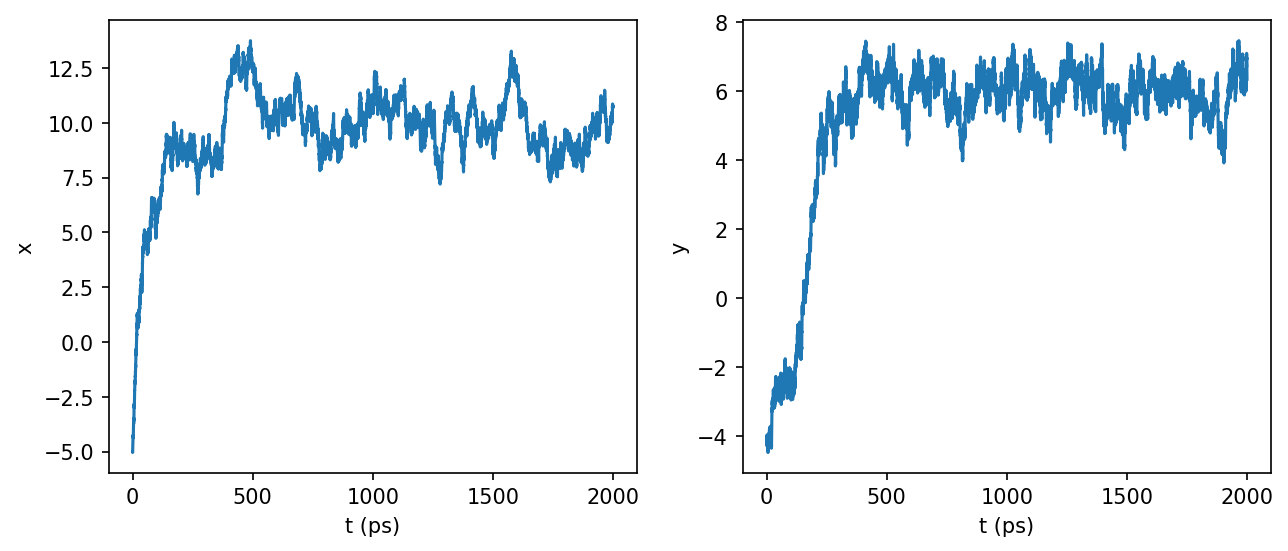

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
ax[0].plot(t, traj[:, 0])
ax[1].plot(t, traj[:, 1])
ax[0].set_xlabel("t (ps)")
ax[1].set_xlabel("t (ps)")
ax[0].set_ylabel("x")
ax[1].set_ylabel("y")

Let's choose 500 ps (5000 steps) as our equilibration time

(<Figure size 900x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0192f81d0>)

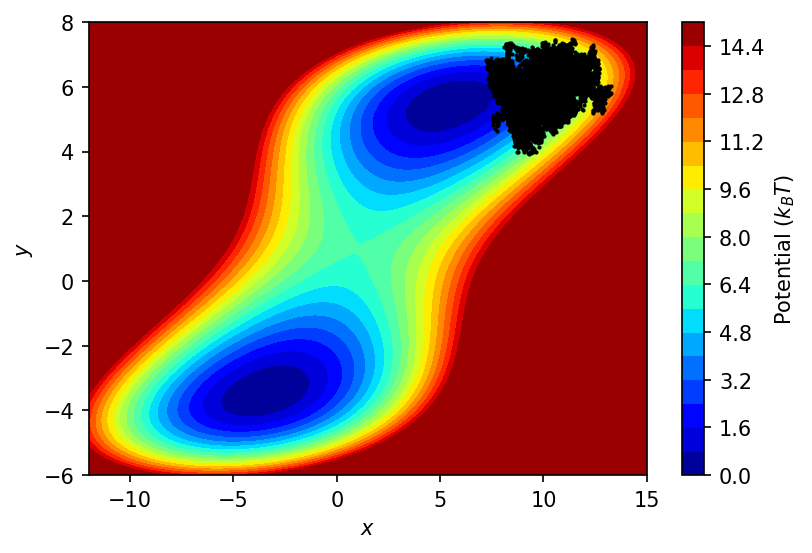

In [16]:
vis.scatter_traj(traj[5000:])

100%|██████████████████████████████████████████████████████████| 1501/1501 [00:03<00:00, 434.74it/s]


(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe019630110>)

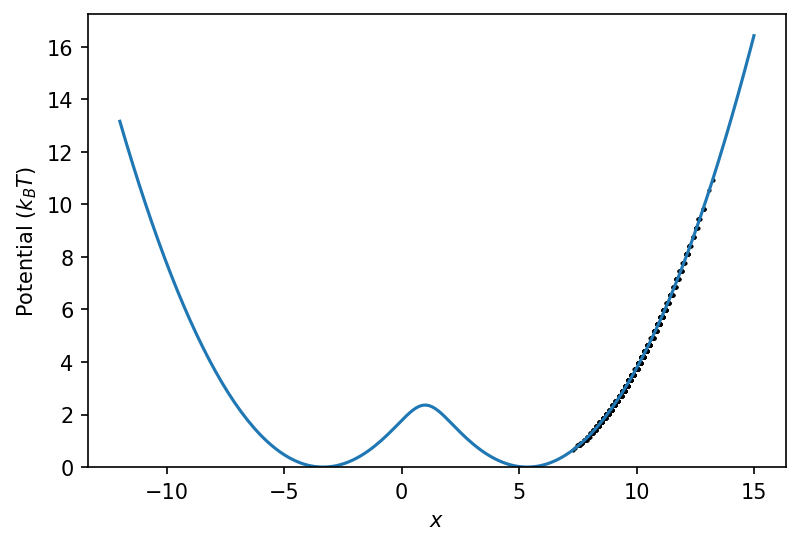

In [17]:
vis.scatter_traj_projection_x(traj[5000::10])  # only every 10, for speed

### Visualizing trajectories from all the windows

(-12.0, 15.0)

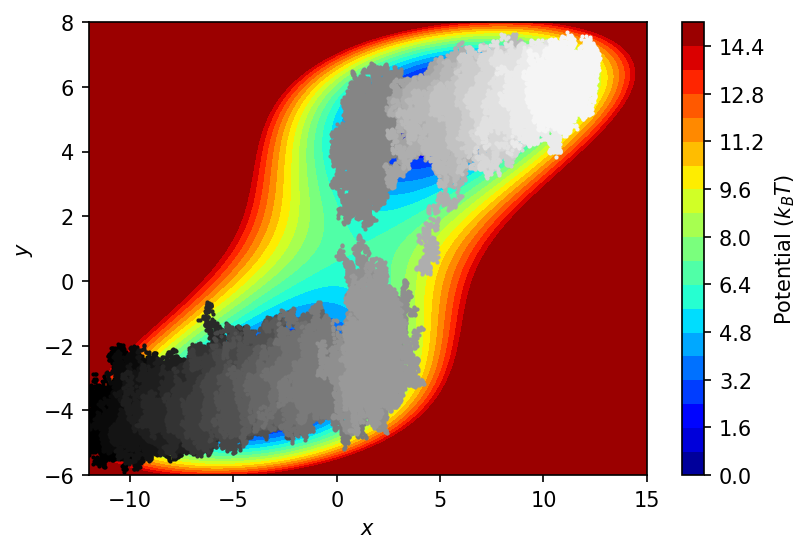

In [24]:
fig, ax = vis.plot_potential()

cm = plt.get_cmap('gist_gray')
ax.set_prop_cycle(color=[cm(1.*i/25) for i in range(25)])

for x_0 in range(-12, 12 + 1, delta_x):
    t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k{}x{}/traj.dat".format(kappa, x_0)).read_traj()
    ax.scatter(traj[5000:, 0], traj[5000:, 1], s=1)
    
ax.set_xlim(-12, 15)

### Visualizing histograms along $x$ coordinate

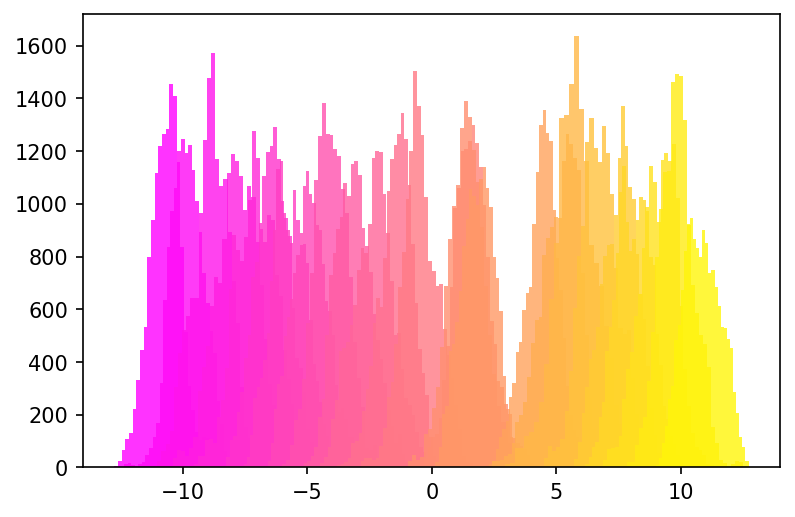

In [32]:
fig, ax = plt.subplots(dpi=150)

cm = plt.get_cmap('spring')
ax.set_prop_cycle(color=[cm(1.*i/25) for i in range(25)])

for x_0 in range(-12, 12 + 1, delta_x):
    t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k{}x{}/traj.dat".format(kappa, x_0)).read_traj()
    ax.hist(traj[5000:, 0], bins=30, alpha=0.8)

## Binless WHAM

We'll now use binless WHAM to construct free energy landscapes from the biased data we collected.

## Binned WHAM